# Notebook

## Load the sample data

In [1]:
import duckdb
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette=sns.color_palette("colorblind"))


DB = "sampled-data/crossref.duckdb"
conn = duckdb.connect(DB)
conn.sql("show tables")

┌─────────┐
│  name   │
│ varchar │
├─────────┤
│ members │
│ works   │
└─────────┘

## Explore characteristics of works sample

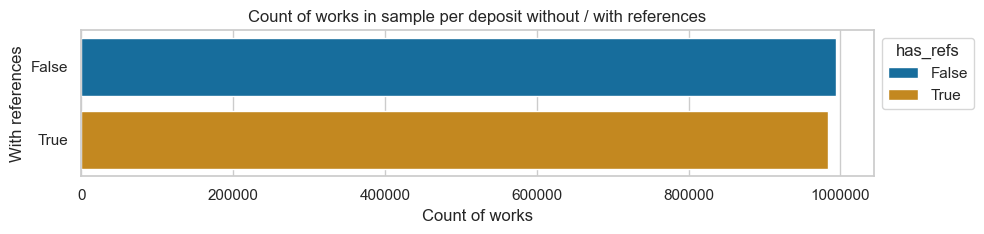

In [17]:
from matplotlib.ticker import ScalarFormatter


fig, (ax) = plt.subplots(1,1, figsize = (10,2.5))

rel = conn.table("works").aggregate("has_refs, count(*) as count")

sns.barplot(
    ax=ax,
    data=rel.df(),
    y="has_refs",
    hue="has_refs",
    x='count',
    orient="y"
).set_title("Count of works in sample per deposit without / with references")
ax.set_ylabel("With references")
ax.set_xlabel("Count of works")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.ticklabel_format(style='plain', axis='x')

plt.tight_layout()
fig.savefig("vis/sample_has_refs_distribution.png")

In [11]:
type_proportion_sql = """
WITH work_count AS (SELECT work_type, count(*) AS type_count FROM works GROUP BY work_type)

SELECT w.work_type, has_refs as "has references", count(*)/wc.type_count proportion
FROM works w
LEFT JOIN work_count wc ON w.work_type = wc.work_type
GROUP BY (w.work_type, w.has_refs, wc.type_count)
HAVING type_count IS NOT NULL
ORDER BY wc.type_count desc
"""

conn.sql(type_proportion_sql).limit(4)

┌─────────────────┬────────────────┬────────────────────┐
│    work_type    │ has references │     proportion     │
│     varchar     │    boolean     │       double       │
├─────────────────┼────────────────┼────────────────────┤
│ journal-article │ true           │ 0.5839864974730586 │
│ journal-article │ false          │ 0.4160135025269414 │
│ book-chapter    │ true           │ 0.3714946935876236 │
│ book-chapter    │ false          │ 0.6285053064123765 │
└─────────────────┴────────────────┴────────────────────┘

In [13]:
import numpy as np


percentage_labels = [float(round(i,1)) for i in np.linspace(0,1,11)]
percentage_labels

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

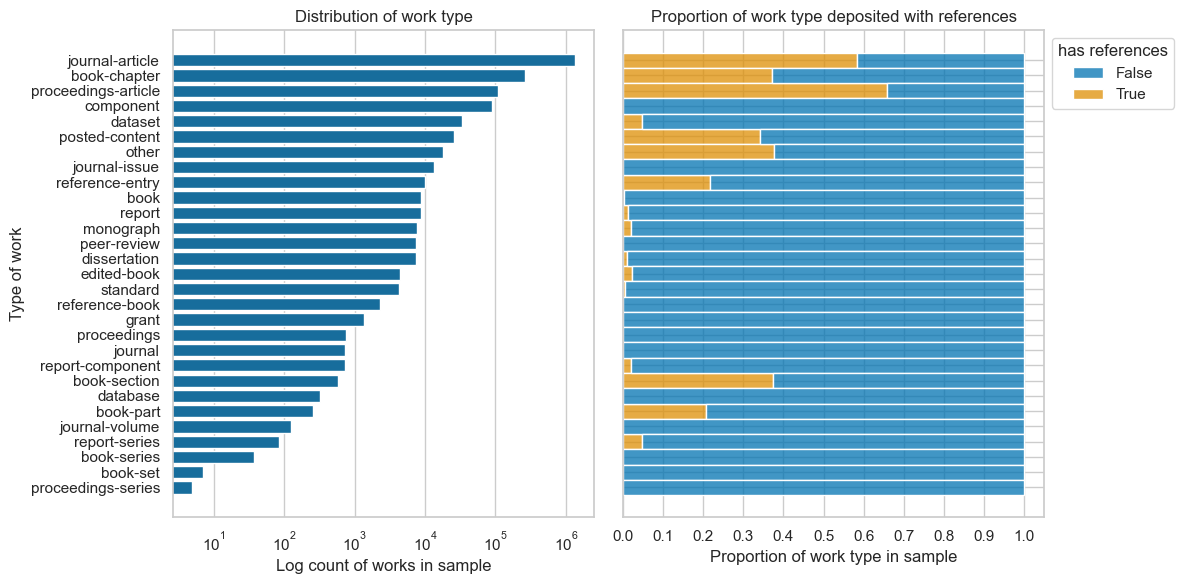

In [18]:
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize = (12,6), sharey=True)

df = conn.table("works").aggregate("work_type, count(*) as count").order("count desc").df()
sns.barplot(
    ax=ax1,
    data=df,
    y="work_type",
    x="count",
).set_title("Distribution of work type")
ax1.set_ylabel("Type of work")
ax1.set_xlabel("Log count of works in sample")
ax1.set_xscale("log")

df = conn.sql(type_proportion_sql).df()
sns.histplot(
    ax=ax2,
    data=df,
    y="work_type",
    hue="has references",
    weights='proportion',
    multiple="stack"
).set_title("Proportion of work type deposited with references")
ax2.set_ylabel("Type of work")
ax2.set_xlabel("Proportion of work type in sample")
ax2.set_xticks(np.linspace(0,1,11), labels=percentage_labels)
sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1))

# plt.suptitle("Distribution of sample\nn = 1 978 118")

plt.tight_layout()
fig.savefig("vis/sample_work_type_distribution.png")

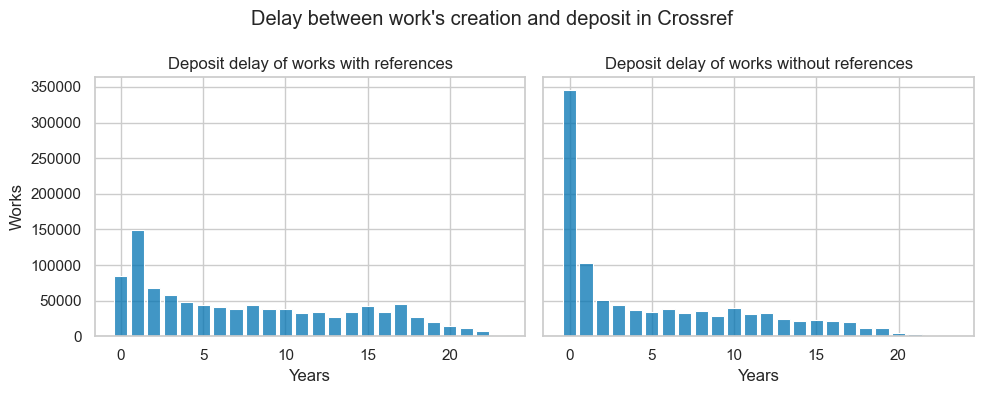

In [19]:
def make_subplot(df, ax, title, ylabel:str = "Works"):
    sns.histplot(
        ax=ax,
        data=df, 
        x="delay",
        discrete=True,
        shrink=.8,
    ).set_title(title)
    ax.set_xlabel("Years")
    ax.set_ylabel(ylabel)


fig, ((ax1, ax2)) = plt.subplots(1,2, figsize = (10,4), sharex=True, sharey="row")

df1 = conn.table("works").filter("has_refs = True").select('ceil(deposit_delay_days/365) as delay').df()
make_subplot(df=df1, ax=ax1, title="Deposit delay of works with references")

df2 = conn.table("works").filter("has_refs = False").select('ceil(deposit_delay_days/365) as delay').df()
make_subplot(df=df2, ax=ax2, title="Deposit delay of works without references")

# df3 = conn.table("works").filter("has_refs = True and work_type = 'journal-article'").select('ceil(deposit_delay_days/365) as delay').df()
# make_subplot(df=df3, ax=ax3, title="Journal articles with references", ylabel="Journal articles")

# df4 = conn.table("works").filter("has_refs = False and work_type = 'journal-article'").select('ceil(deposit_delay_days/365) as delay').df()
# make_subplot(df=df4, ax=ax4, title="Journal articles without references", ylabel="Journal articles")

fig.suptitle("Delay between work's creation and deposit in Crossref")

plt.tight_layout()
fig.savefig("vis/sample_deposit_delay_per_has_refs.png")